# Processing Data where LLMs were asked directly 

Starting Point:
- direct LLM answers (one DF per model, with answers to 5 scales)

Goal:
- build df so that DVs for each scale for each model
- then I can test test-retest corr (or however to call it) between this version of getting a DV per scale and the human values based version

In [465]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns


In [466]:
# load data
def load_dataframes(path = "LLM_data/ask_directly_outputs/"):

    # Initialize empty list to store DataFrames
    dataframe = []

    path = path  # folder with CSVs of LLM answers
    #print(glob.glob(os.path.join(path, f"*_Outline_ask_LLM_models_directly_results.csv")))
    for file in glob.glob(os.path.join(path, f"*_Outline_ask_LLM_models_directly_results.csv")):
        
        model_name = os.path.basename(file).replace(f"*_Outline_ask_LLM_models_directly_results.csv", "")
        #print(model_name)
        # Read the CSV
        df = pd.read_csv(file)
        
        # Append to list
        dataframe.append(df)
        
    # Concatenate all DataFrames into one big DataFrame
    merged_data = pd.concat(dataframe, ignore_index=True)

    print(f"Merged DataFrame shape: {merged_data.shape}")
    print(f"Total models: {merged_data['model'].nunique()}")

    return(merged_data)

LLM_data = load_dataframes(path = "LLM_data/ask_directly_outputs/")

Merged DataFrame shape: (9632, 18)
Total models: 43


In [467]:
LLM_data["experiment"].unique()

array(['Decisions From Description', 'BARRAT scale', 'DOSPERT scale',
       'SOEP scale', 'SSSV scale'], dtype=object)

### Add categories for DOSPERT and revert flipped answers

In [468]:
# Adding task specific categories to save in all data

# add item categories
item_to_category = {
    1: "Dsoc", 10: "Dsoc", 16: "Dsoc", 19: "Dsoc", 23: "Dsoc", 26: "Dsoc", 34: "Dsoc", 35: "Dsoc",
    2: "Drec", 6: "Drec", 15: "Drec", 17: "Drec", 21: "Drec", 31: "Drec", 37: "Drec", 38: "Drec",
    3: "Dgam", 11: "Dgam", 22: "Dgam", 33: "Dgam",
    4: "Dhea", 8: "Dhea", 27: "Dhea", 29: "Dhea", 32: "Dhea", 36: "Dhea", 39: "Dhea", 40: "Dhea",
    5: "Deth", 9: "Deth", 12: "Deth", 13: "Deth", 14: "Deth", 20: "Deth", 25: "Deth", 28: "Deth",
    7: "Dinv", 18: "Dinv", 24: "Dinv", 30: "Dinv"
}

mask = LLM_data["experiment"] == "DOSPERT scale"

LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)

In [469]:
# flip back human answers where they were flipped
mask = (LLM_data["experiment"] == "DOSPERT scale") & (LLM_data["flipped"] == "yes")
LLM_data.loc[mask, "model_answer"] = 6 - LLM_data.loc[mask, "model_answer"]


### Add categories for SOEP scale and revert flipped answers

In [470]:
# add item categories
item_to_category = {
     1: "SOEP", 2: "SOEPdri", 3: "SOEPfin",  4: "SOEPrec", 5: "SOEPocc",  6: "SOEPhea",  7: "SOEPsoc"
}
mask = LLM_data["experiment"] == "SOEP scale"
LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)

In [471]:
# flip back human answers where they were flipped
mask = (LLM_data["experiment"] == "SOEP scale") & (LLM_data["flipped"] == "yes")
LLM_data.loc[mask, "model_answer"] = 12 - LLM_data.loc[mask, "model_answer"]

### Process BARRAT scale

In [472]:
# flip back model answers where they were flipped
mask = (LLM_data["experiment"] == "BARRAT scale") & (LLM_data["flipped"] == "True")
LLM_data.loc[mask, "model_answer"] = 5 - LLM_data.loc[mask, "model_answer"]


In [473]:

# add item categories
item_to_category = {
    1: "BISn", 2: "BISm", 3: "BISm",  4: "BISm", 5: "BISa",  6: "BISa",  7: "BISn",  8: "BISn",  9: "BISa",  10: "BISn",
    11: "BISa", 12: "BISn", 13: "BISn",  14: "BISn", 15: "BISn",  16: "BISm",  17: "BISm",  18: "BISn",  19: "BISm",  20: "BISa",
    21: "BISm", 22: "BISm", 23: "BISm",  24: "BISa", 25: "BISm",  26: "BISa",  27: "BISn",  28: "BISa",  29: "BISn",  30: "BISm"
}
# add whether item was reverse coded
reverse_coded = {
    1: True, 2: False, 3: False,  4: False, 5: False,  6: False,  7: True,  8: True,  9: True,  10: True,
    11: False, 12: True, 13: True,  14: False, 15: True,  16: False,  17: False,  18: False,  19: False,  20: True,
    21: False, 22: False, 23: False,  24: False, 25: False,  26: False,  27: False,  28: False,  29: True,  30: True
    }
mask = LLM_data["experiment"] == "BARRAT scale"

LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)
LLM_data.loc[mask, "reverse_coded"] = LLM_data.loc[mask, "item"].map(reverse_coded)


In [474]:
# flip back answers that where reverse coded
mask = (LLM_data["experiment"] == "BARRAT scale") & (LLM_data["reverse_coded"] == True)
LLM_data.loc[mask, "model_answer"] = 5 - LLM_data.loc[mask, "model_answer"]
# drop reverse-coded column (not needed in final data)
LLM_data = LLM_data.drop(columns=["reverse_coded"])


### Process SSSV scale - bug (ignore until later)

In [475]:
LLM_data = LLM_data[LLM_data["experiment"] != "SSSV scale"]

In [476]:
# for q in sssv["question"].head(40):
#     print(f"1: {q}")

In [477]:
# # flip back human answers where they were flipped
# mask = (LLM_data["experiment"] == "SSSV scale") & (LLM_data["flipped"] == "True")
# LLM_data.loc[mask, "model_answer"] = 3 - LLM_data.loc[mask, "model_answer"]


In [478]:
# # Adding task specific categories to save in all data

# # add item categories
# item_to_category = {
#      3: "SStas", 11: "SStas", 16: "SStas", 17: "SStas", 20: "SStas", 21: "SStas", 23: "SStas", 28: "SStas", 38: "SStas", 40: "SStas",
#      4: "SSexp", 6: "SSexp", 9: "SSexp", 10: "SSexp", 14: "SSexp", 18: "SSexp", 19: "SSexp", 22: "SSexp", 26: "SSexp", 37: "SSexp",
#      1: "SSdis", 12: "SSdis", 13: "SSdis", 25: "SSdis", 29: "SSdis", 30: "SSdis", 32: "SSdis", 33: "SSdis", 35: "SSdis", 36: "SSdis",
#      2: "SSbor", 5: "SSbor", 7: "SSbor", 8: "SSbor", 15: "SSbor", 24: "SSbor", 27: "SSbor", 31: "SSbor", 34: "SSbor", 39: "SSbor"
# }

# reverse_coded = {
#      1: True, 2: False, 3: True, 4: False, 5: True, 6: True, 7: False, 8: True, 9: True, 10: False, 
#      11: False, 12: False, 13: False, 14: True, 15: False, 16: True, 17: True, 18: True, 19: False, 20: False,
#      21: False, 22: True, 23: True, 24: True, 25: False, 26: False, 27: False, 28: True, 29: True, 30: False,
#      31: False, 32: True, 33: False, 34: True, 35: False, 36: True, 37: False, 38: False, 39: True, 40: False

# }

# mask = LLM_data["experiment"] == "SSSV scale"

# LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)
# LLM_data.loc[mask, "reverse_coded"] = LLM_data.loc[mask, "item"].map(reverse_coded)

# # flip back answers that where reverse coded
# # mask = (LLM_data["experiment"] == "SSSV scale") & (LLM_data["reverse_coded"] == True)
# # LLM_data.loc[mask, "model_answer"] = 3 - LLM_data.loc[mask, "model_answer"]
# # drop reverse-coded column (not needed in final data)
# LLM_data = LLM_data.drop(columns=["reverse_coded"])


In [479]:
# sssv = LLM_data[LLM_data["experiment"] == "SSSV scale"]
# sssv_wide = sssv.pivot_table(
#     index="model",  
#     columns="item",
#     values="model_answer"
# )
# corr_matrix = sssv_wide.corr()
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(22, 20))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
# plt.title("Correlation Matrix of SSSV Items - when reverse items NOT turned back")
# plt.show()

In [480]:
# sssv = LLM_data[LLM_data["experiment"] == "SSSV scale"]
# sssv_wide = sssv.pivot_table(
#     index="model",  
#     columns="item",
#     values="model_answer"
# )
# corr_matrix = sssv_wide.corr()
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(22, 20))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
# plt.title("Correlation Matrix of SSSV Items - when reverse items turned back")
# plt.show()


### DFD task 

In [481]:
# renaming for consistency
LLM_data["experiment"] = LLM_data["experiment"].replace(
    "Decisions From Description",
    "DFD"
)

In [482]:
# rename item names 
item_to_name = {
    1: "he04_6inv",
    2: "he04_3",
    3: "he04_1",
    4: "he04_2",
    5: "he04_2inv",
    6: "he04_5",
    7: "he04_6",
    8: "he04_4"
}

mask = LLM_data["experiment"] == "DFD"

LLM_data.loc[mask, "item"] = (
    LLM_data.loc[mask, "item"]
    .astype(int)
    .map(item_to_name)
)


/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_24739/2548872299.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['he04_6inv' 'he04_3' 'he04_1' 'he04_2' 'he04_2inv' 'he04_5' 'he04_6'
 'he04_4' 'he04_6inv' 'he04_3' 'he04_1' 'he04_2' 'he04_2inv' 'he04_5'
 'he04_6' 'he04_4' 'he04_6inv' 'he04_3' 'he04_1' 'he04_2' 'he04_2inv'
 'he04_5' 'he04_6' 'he04_4' 'he04_6inv' 'he04_3' 'he04_1' 'he04_2'
 'he04_2inv' 'he04_5' 'he04_6' 'he04_4' 'he04_6inv' 'he04_3' 'he04_1'
 'he04_2' 'he04_2inv' 'he04_5' 'he04_6' 'he04_4' 'he04_6inv' 'he04_3'
 'he04_1' 'he04_2' 'he04_2inv' 'he04_5' 'he04_6' 'he04_4' 'he04_6inv'
 'he04_3' 'he04_1' 'he04_2' 'he04_2inv' 'he04_5' 'he04_6' 'he04_4'
 'he04_6inv' 'he04_3' 'he04_1' 'he04_2' 'he04_2inv' 'he04_5' 'he04_6'
 'he04_4' 'he04_6inv' 'he04_3' 'he04_1' 'he04_2' 'he04_2inv' 'he04_5'
 'he04_6' 'he04_4' 'he04_6inv' 'he04_3' 'he04_1' 'he04_2' 'he04_2inv'
 'he04_5' 'he04_6' 'he04

In [483]:
# "translate" model choices into risky vs. not risky decision scores
what_risky = {
    "he04_6inv": 2,
    "he04_3": 2,
    "he04_1": 1,
    "he04_2": 1,
    "he04_2inv": 2,
    "he04_5": 1,
    "he04_6": 1,
    "he04_4": 2
}

# nur für das relevante Experiment 
mask = LLM_data["experiment"] == "DFD"

# neuen Score berechnen: 1, wenn model_answer riskant ist, sonst 0
LLM_data.loc[mask, "model_answer"] = LLM_data.loc[mask].apply(
    lambda row: 1 if row["model_answer"] == what_risky.get(row["item"]) else 0,
    axis=1
)


In [484]:
# Adding task specific categories to save in all data

# add item categories, some where loss and some where win decisions
item_to_category = {
    'he04_6inv': 'DFD_loss', 'he04_1': 'DFD_gain', 'he04_5': 'DFD_gain', 'he04_6': 'DFD_gain', 'he04_3': 'DFD_loss', 'he04_2': 'DFD_gain',
       'he04_4': 'DFD_loss', 'he04_2inv': 'DFD_loss'
}
mask = LLM_data["experiment"] == "DFD"
LLM_data.loc[mask, "category"] = LLM_data.loc[mask, "item"].map(item_to_category)


## Reliability Analysis

In [485]:
# function:
def compute_cronbach_alpha(score = "model_answer"):
    results = []

    # loop through experiments
    for exp, exp_data in LLM_data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))

alpha_df = compute_cronbach_alpha()


In [486]:
alpha_df

,experiment,domain,alpha,alpha_CI
0,BARRAT scale,BISa,0.684289,"[0.519, 0.809]"
1,BARRAT scale,BISm,0.743456,"[0.613, 0.844]"
2,BARRAT scale,BISn,0.807740,"[0.71, 0.883]"
3,DFD,DFD_gain,0.715308,"[0.545, 0.833]"
4,DFD,DFD_loss,0.588465,"[0.343, 0.758]"
5,DOSPERT scale,Deth,0.945070,"[0.916, 0.967]"
6,DOSPERT scale,Dgam,0.892386,"[0.828, 0.937]"
7,DOSPERT scale,Dhea,0.909056,"[0.861, 0.945]"
8,DOSPERT scale,Dinv,0.664577,"[0.465, 0.803]"
9,DOSPERT scale,Drec,0.762693,"[0.638, 0.856]"


## Correlations within LLM output data

#### Calculate overall model scores

In [487]:
BARRAT_SUB= LLM_data[LLM_data["experiment"] == "BARRAT scale"]
BARRAT_DV_DF = BARRAT_SUB.groupby(["model", "category"])["model_answer"].sum().reset_index()
BARRAT_DV_DF = BARRAT_DV_DF.pivot(index="model", columns="category", values="model_answer")



In [488]:
DOSPERT_SUB= LLM_data[LLM_data["experiment"] == "DOSPERT scale"]
DOSPERT_DV_DF = DOSPERT_SUB.groupby(["model", "category"])["model_answer"].mean().reset_index()
DOSPERT_DV_DF = DOSPERT_DV_DF.pivot(index="model", columns="category", values="model_answer")

DV_data = pd.merge(BARRAT_DV_DF, 
                    DOSPERT_DV_DF, 
                    on="model",
                    how = "outer")

In [489]:
DV_data

category,BISa,BISm,BISn,Deth,Dgam,Dhea,Dinv,Drec,Dsoc
model,,,,,,,,,
Apertus-8B-Instruct-2509,40.0,56.0,55.0,3.0000,3.000000,3.0000,3.000,3.062500,3.000000
Falcon-3-10B-Instruct,29.0,37.0,34.0,1.0625,1.000000,1.2500,3.625,2.500000,3.437500
Falcon-3-1B-Instruct,26.0,37.0,54.0,3.0000,3.000000,3.0000,3.250,3.000000,3.000000
Falcon-3-7B-Instruct,31.0,48.0,40.0,1.0625,1.500000,1.4375,4.250,2.187500,3.000000
LFM2-1.2B,34.0,40.0,64.0,3.0000,3.000000,3.0000,3.000,3.000000,3.000000
LFM2-2.6B,36.0,52.0,41.0,2.0000,2.250000,2.5000,4.125,3.187500,3.750000
LFM2-8B-A1B,40.0,53.0,53.0,3.0000,3.000000,2.8125,3.000,3.000000,3.000000
Llama-3.1-8B-Instruct,22.0,43.0,31.0,1.5000,1.000000,2.5625,3.500,2.312500,3.562500
Llama-3.2-1B-Instruct,40.0,55.0,55.0,3.0000,3.000000,3.0000,3.000,3.000000,3.000000


In [491]:
SOEP_SUB= LLM_data[LLM_data["experiment"] == "SOEP scale"]
SOEP_DV_DF = SOEP_SUB.groupby(["model", "category"])["model_answer"].mean().reset_index()
SOEP_DV_DF = SOEP_DV_DF.pivot(index="model", columns="category", values="model_answer")
# add_new_df
DV_data = pd.merge(
    DV_data,
    SOEP_DV_DF,
    on="model",
    how="outer"
)

In [492]:
# DFD
DFD_SUB= LLM_data[LLM_data["experiment"] == "DFD"]
DFD_DV_DF = DFD_SUB.groupby(["model"])["model_answer"].mean().reset_index()

# add_new_df
DV_data = pd.merge(
    DV_data,
    DFD_DV_DF[["model", "model_answer"]].rename(columns={"model_answer": "DFD"}),
    on="model",
    how="outer"
)

In [493]:
DV_data

,model,BISa,BISm,BISn,Deth,Dgam,Dhea,Dinv,Drec,Dsoc,SOEP,SOEPdri,SOEPfin,SOEPhea,SOEPocc,SOEPrec,SOEPsoc,DFD
0,Apertus-8B-Instruct-2509,40.0,56.0,55.0,3.0000,3.000000,3.0000,3.000,3.062500,3.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.500
1,Falcon-3-10B-Instruct,29.0,37.0,34.0,1.0625,1.000000,1.2500,3.625,2.500000,3.437500,6.0,6.0,6.0,6.0,6.0,6.0,5.0,0.500
2,Falcon-3-1B-Instruct,26.0,37.0,54.0,3.0000,3.000000,3.0000,3.250,3.000000,3.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.500
3,Falcon-3-7B-Instruct,31.0,48.0,40.0,1.0625,1.500000,1.4375,4.250,2.187500,3.000000,7.0,7.0,5.5,7.0,7.0,7.0,7.0,0.500
4,LFM2-1.2B,34.0,40.0,64.0,3.0000,3.000000,3.0000,3.000,3.000000,3.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.500
5,LFM2-2.6B,36.0,52.0,41.0,2.0000,2.250000,2.5000,4.125,3.187500,3.750000,6.0,6.0,6.0,7.0,6.5,6.0,8.0,0.375
6,LFM2-8B-A1B,40.0,53.0,53.0,3.0000,3.000000,2.8125,3.000,3.000000,3.000000,6.0,4.0,6.0,6.0,6.0,6.0,6.0,0.375
7,Llama-3.1-8B-Instruct,22.0,43.0,31.0,1.5000,1.000000,2.5625,3.500,2.312500,3.562500,7.0,7.5,5.0,4.5,6.5,6.5,2.5,0.625
8,Llama-3.2-1B-Instruct,40.0,55.0,55.0,3.0000,3.000000,3.0000,3.000,3.000000,3.000000,6.0,6.0,6.0,6.0,6.0,6.0,6.0,0.625
9,Llama-3.2-3B-Instruct,40.0,55.0,53.0,3.0000,3.000000,3.0000,3.000,3.000000,3.187500,8.5,8.0,6.0,6.0,5.5,6.0,6.0,0.500


## Correlations between model aswers of different tasks

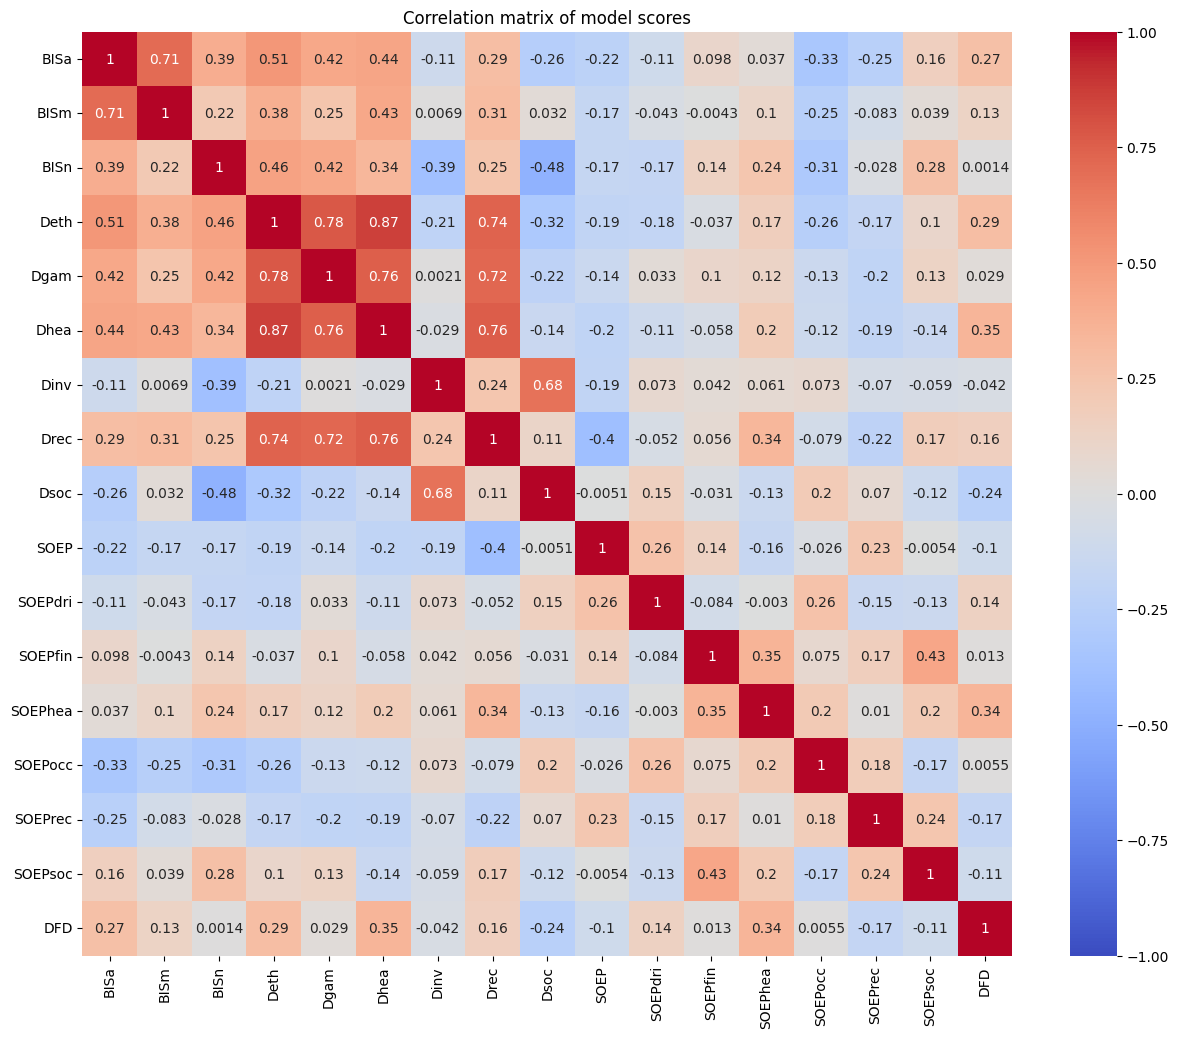

In [494]:
# get df in wide format
DV_data_for_corr = DV_data.drop(columns=['model'])

corr_matrix = DV_data_for_corr.corr()
# Display it as a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores")
plt.show()


In [495]:
DV_data.to_csv('processed_data/LLM_direct_answers_DVs.csv', index=True)

## Correlations same task LLM outputs versus human-LLM data

In [496]:
# read data
LLM_human_data = pd.read_csv("processed_data/final_Dvs.csv")
ask_directly_LLM_data = pd.read_csv("processed_data/LLM_direct_answers_DVs.csv")

In [497]:
common_cols = LLM_human_data.columns.intersection(ask_directly_LLM_data.columns)
common_cols = common_cols.drop("model")
print(common_cols)

Index(['BISa', 'BISm', 'BISn', 'Deth', 'Dgam', 'Dhea', 'Dinv', 'Drec', 'Dsoc',
       'SOEP', 'SOEPdri', 'SOEPfin', 'SOEPhea', 'SOEPocc', 'SOEPrec',
       'SOEPsoc', 'DFD'],
      dtype='object')


In [498]:
LLM_human_data = LLM_human_data.set_index("model")
ask_directly_LLM_data = ask_directly_LLM_data.set_index("model")

# Keep only matching models
LLM_human_data, ask_directly_LLM_data = LLM_human_data.align(ask_directly_LLM_data, join="inner")


In [499]:
correlations = {}

for col in common_cols:
    # align rows by index (model order)
    correlations[col] = LLM_human_data[col].corr(ask_directly_LLM_data[col])

correlations = pd.Series(correlations).sort_values(ascending=False)

corr_df = pd.DataFrame({
    "measure": correlations.index,
    "test_retest_r": correlations.values
})
corr_df

,measure,test_retest_r
0,BISm,0.328550
1,Dsoc,0.301985
2,BISa,0.196827
3,SOEPrec,0.194366
4,SOEPocc,0.183160
5,SOEPfin,0.170128
6,Deth,0.127659
7,BISn,0.117561
8,Dhea,0.096203
9,SOEPdri,0.042901


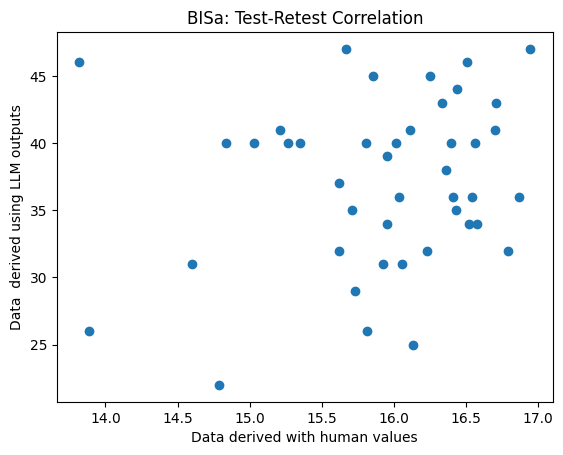

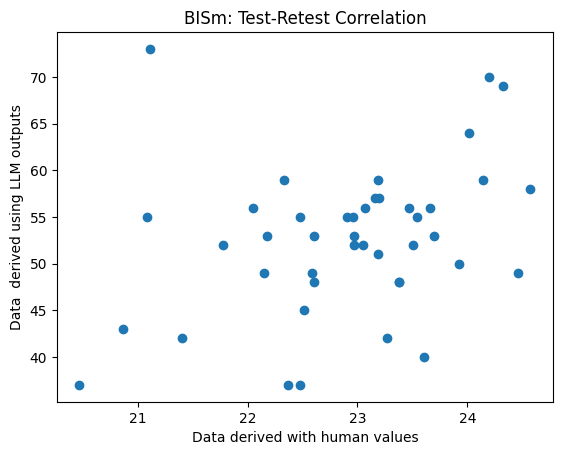

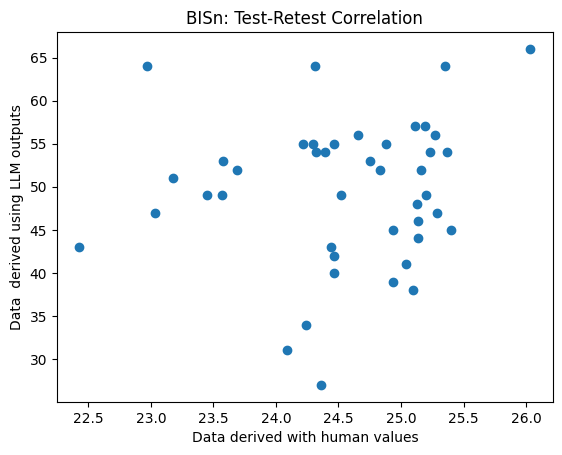

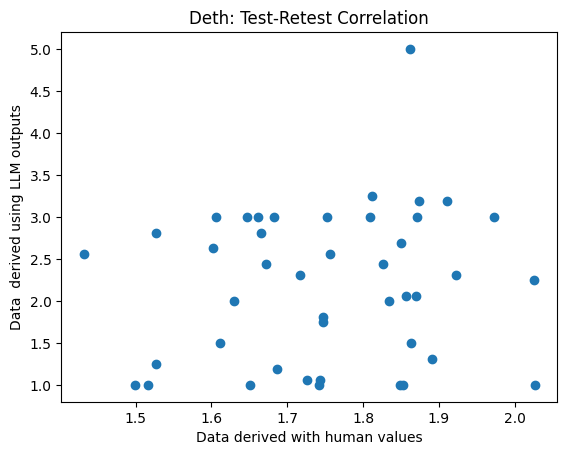

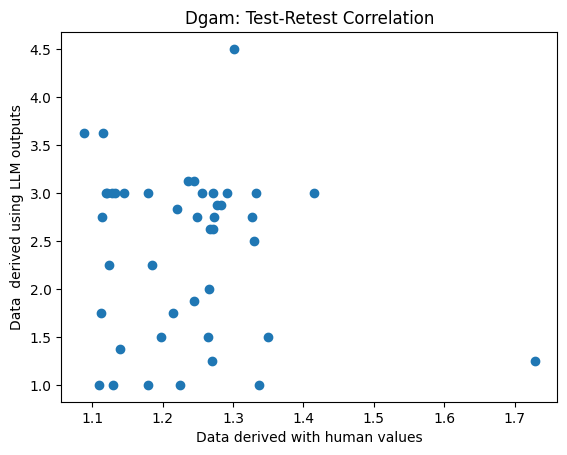

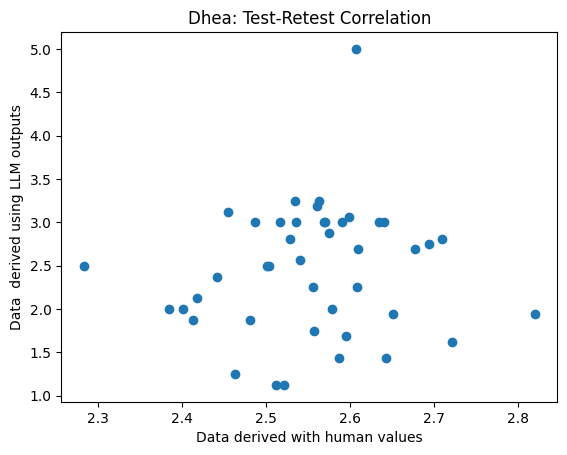

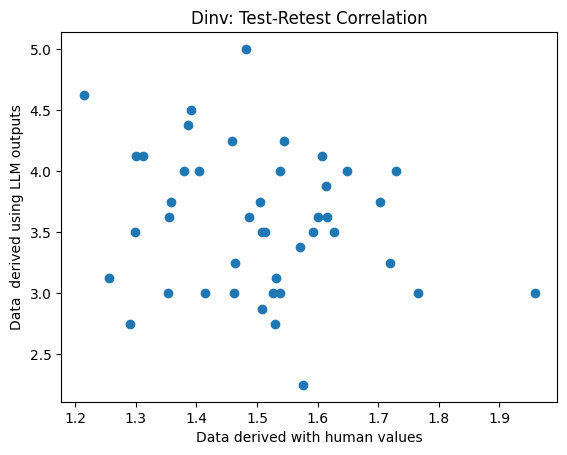

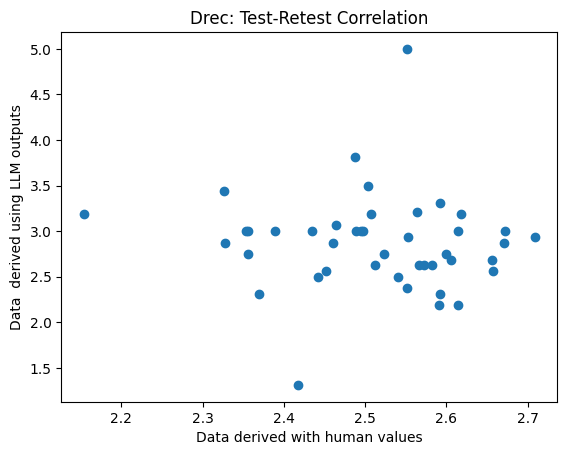

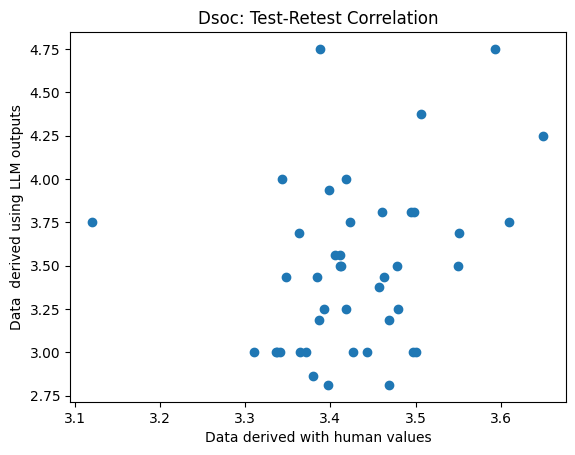

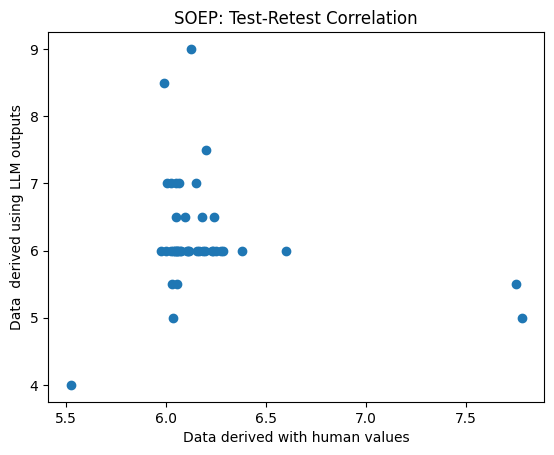

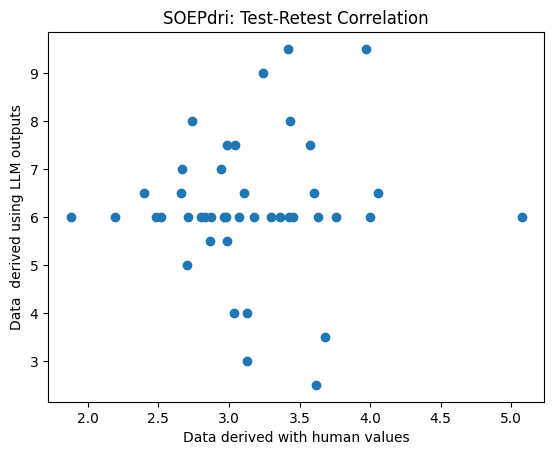

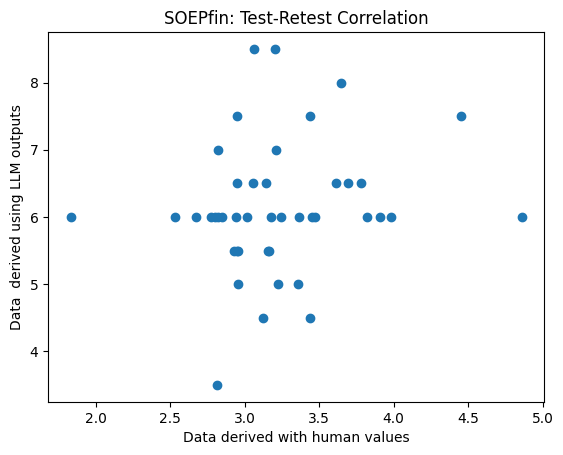

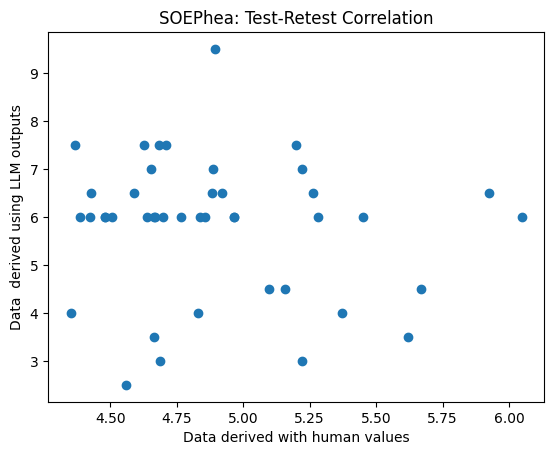

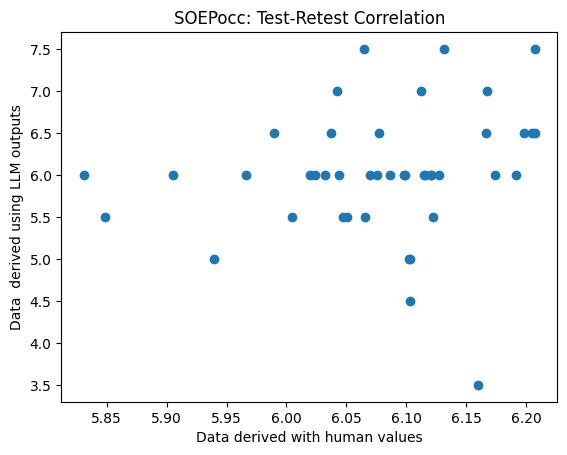

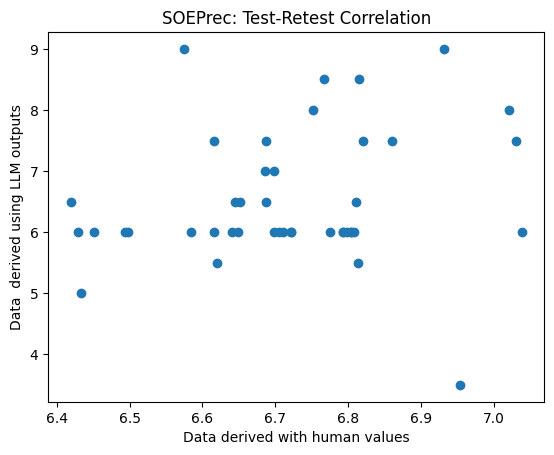

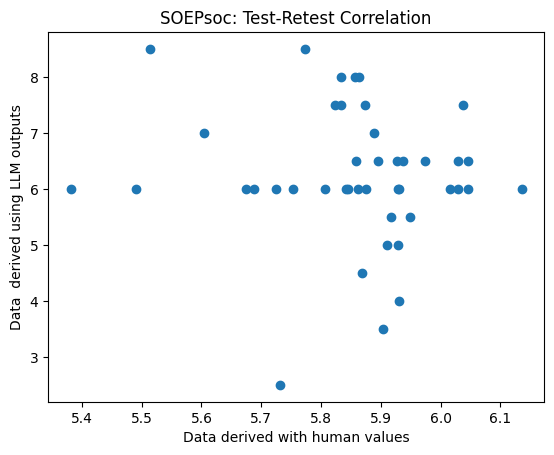

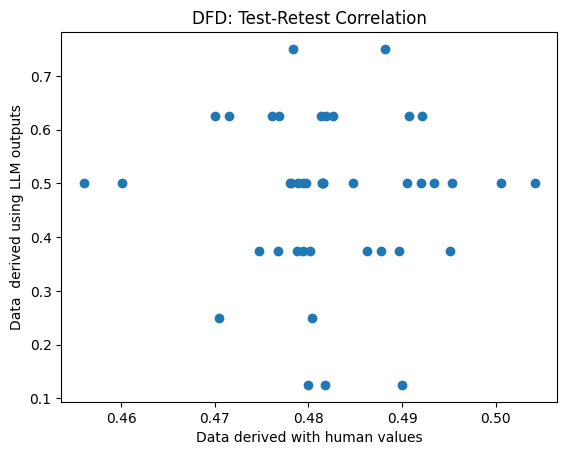

In [500]:
import matplotlib.pyplot as plt

for col in common_cols:
    plt.figure()
    plt.scatter(LLM_human_data[col], ask_directly_LLM_data[col])
    plt.title(f"{col}: Test-Retest Correlation")
    plt.xlabel("Data derived with human values")
    plt.ylabel("Data  derived using LLM outputs")
    plt.show()
